# Final Report 
Group members: Loay Al-Abri, 


(2) Methods and Results

In this section, you will include:


b) “Methods: Plan”

    - Describe in written English the methods you used to perform your analysis from beginning to end, and narrate the code that does the analysis.
    - If included, describe the “Feature Selection” process and how and why you choose the covariates of your final model.
    - Make sure to interpret/explain the results you obtain. It’s not enough to just say, “I fitted a linear model with these covariates, and my R-square is 0.87”.
        - If inference is the aim of your project, a detailed interpretation of your fitted model is required, as well as a discussion of relevant quantities (e.g., are the coefficients significant? How does the model fit the data)?
        - A careful model assessment must be conducted.
        - If prediction is the project's aim, describe the test data used or how it was created.
    - Ensure your tables and/or figures are labelled with a figure/table number.


Questions:
- How is the stars of a repository related to forks, issues, size, and discussion setting?

In this project, we will perform analysis on the number of Stars a GitHub repository has using the most essential variables that affect the number of Stars a GitHub Repository might get. To start with, we will use to baseline models to compare our model's performance with. The first baseline model is a model where we always perdict the mean number of stars. We expect this model to have $R^2$ close to 0. and it will have poor performance. The second baseline model we will use is a linear regression model that includes all the variables in the dataset as explanatory variables. Thus, our final model should perform better than the maximal model because the explanatory data analysis showed that the variables we chose are the once most essentail determining the number of stars a repository has. Finally, we will diagnose our model to examine whether any of the linear regression assumptions are violated. 

In [11]:
library(tidyverse)
library(tidymodels)
library(Metrics)
library(ggplot2)
library(broom)
library(GGally)
library(gridExtra)
library(cowplot)

In [12]:
git_rep <- read.csv("data/repositories.csv") %>%
    select(-Name, -Homepage, -URL, -Topics, -License, -Description,-`Created.At`, -`Updated.At`, -Language, -Watchers,
     - Is.Fork) %>%
     mutate(
        Default_branch = case_when(
            `Default.Branch` == "master" ~ "master",
            `Default.Branch` == "main" ~ "main",
            TRUE ~ "other"
        )
    ) %>%
    select(-`Default.Branch`) %>%
    mutate(Has.Issues = as.factor(Has.Issues),
           Has.Projects = as.factor(Has.Projects),
           Has.Downloads = as.factor(Has.Downloads),
           Has.Wiki = as.factor(Has.Wiki),
           Has.Pages = as.factor(Has.Pages),
           Has.Discussions = as.factor(Has.Discussions),
           Is.Archived = as.factor(Is.Archived),
           Is.Template = as.factor(Is.Template)
           )
set.seed(1234)
git_split <- initial_split(git_rep, prop = 0.75, strata = Stars)
git_tr <- training(git_split)
git_te <- testing(git_split)
head(git_tr)

,Size,Stars,Forks,Issues,Has.Issues,Has.Projects,Has.Downloads,Has.Wiki,Has.Pages,Has.Discussions,Is.Archived,Is.Template,Default_branch
,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,2411,237,32,36,True,True,True,False,False,False,False,False,master
2,685,237,28,9,True,True,True,True,False,True,False,False,master
3,900,237,36,23,True,False,True,True,True,False,False,False,master
4,306952,237,74,57,True,True,True,True,False,True,False,False,main
5,679,237,72,17,True,True,False,True,False,False,False,False,master
6,31555,237,47,40,True,False,True,False,False,False,False,False,master


In [33]:
compute_r_sqr <- function(y_actual, y_predicted) {
    SS_residuals <- sum((y_actual - y_predicted)^2)
    SS_total <- sum((y_actual - mean(y_actual))^2)
    R2 <- 1 - (SS_residuals / SS_total)
    return(R2)
}

compute_adj_r <- function(y_actual, y_predicted, p) {
    r2 <- compute_r_sqr(y_actual, y_predicted)
    n <- length(y_actual)
    adj_r2 <- 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return(adj_r2)

}


evaluate_model <- function(model_name, model, results) {
    preds <- predict(model, newdata = git_te, type = "response")
    model_summry <- summary(model)
    model_results <- data.frame(
        Model = c(model_name, model_name),
        data = c("train", "test"),
        r_sqr = c(round(model_summry$r.squared, 2), round(compute_r_sqr(git_te$Stars, preds), 2)),
        rmse = c(round(rmse(git_tr$Stars, model$fitted.values)),
                 round(rmse(git_te$Stars, preds), 2)),
        adj_r_sqr = c(round(model_summry$adj.r.squared, 2), round(compute_adj_r(git_te$Stars, preds, length(coef(model)) - 1), 2))
        )

    new_results <- rbind(results, model_results)
    return(new_results)
}

In [34]:
mean_model <- lm(Stars ~ 1, data = git_tr)
mean_model_summary <- summary(mean_model)
preds <- predict(mean_model, newdata = git_te, type = "response")
results <- evaluate_model("mean model", mean_model, results = data.frame())
results

Model,data,r_sqr,rmse,adj_r_sqr
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean model,train,0,4134.00,0
mean model,test,0,3533.14,0


The results from the mean model are not impressive, but that is expected since the model always predicts the mean number of Stars in the training data. 

In [35]:
full_model <- lm(Stars ~ ., data = git_tr)
full_model_summary <- summary(full_model)

results <- evaluate_model("full model", full_model, results)
results


Model,data,r_sqr,rmse,adj_r_sqr
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean model,train,0.00,4134.00,0.00
mean model,test,0.00,3533.14,0.00
full model,train,0.36,3312.00,0.36
full model,test,0.37,2796.82,0.37


In [36]:
full_model_summary %>% tidy() %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1144.09,99.07,11.55,0.00
Size,0.00,0.00,0.37,0.71
Forks,1.66,0.01,260.89,0.00
Issues,2.55,0.05,54.15,0.00
Has.IssuesTrue,38.94,48.72,0.80,0.42
Has.ProjectsTrue,-264.77,30.34,-8.73,0.00
Has.DownloadsTrue,-239.29,88.91,-2.69,0.01
Has.WikiTrue,-224.23,25.98,-8.63,0.00
Has.PagesTrue,214.88,21.78,9.87,0.00


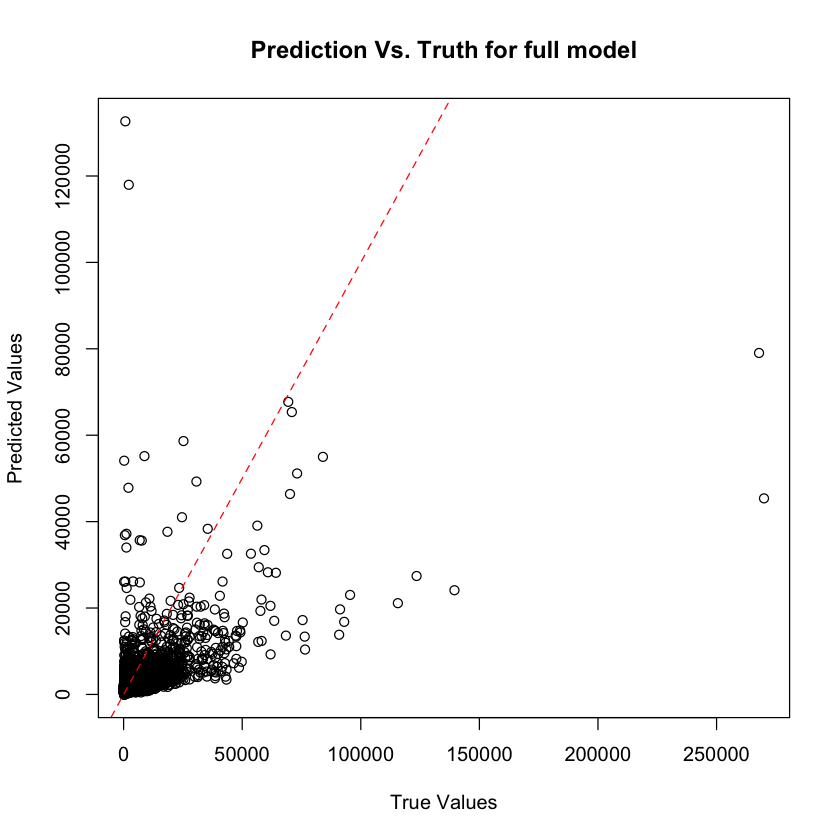

In [79]:
full_preds <- predict(full_model, newdata = git_te, type = "response")
plot(git_te$Stars, full_preds, main = "Prediction Vs. Truth for full model", 
    xlab = "True Values", ylab = "Predicted Values")
abline(a = 0, b = 1, col = "red",lty = 2)

The full model significantly outperforms the mean model, achieving an $R^2$ score of 0.35 on the testing data with a root mean squared error (RMSE) of 3153.77. Additionally, the model does not exhibit overfitting, as the $R^2$ scores and RMSE values for the training and testing datasets are relatively similar. Interestingly, the model's RMSE is lower on the testing set compared to the training set, which may indicate better generalization or potential data-specific characteristics. Now, we will fit a new model using the variables of interest without any interaction terms. Moreover, the predictions are more accurate for lower values of Stars, and the error in the predictions increases as the number of Stars increases. 

In [37]:
model_add <- lm(Stars ~ Issues + Forks + Size + Has.Discussions, data = git_tr)
model_add_summary <- summary(model_add)
model_add_summary %>% tidy() %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),521.05,9.01,57.85,0.00
Issues,2.57,0.05,54.75,0.00
Forks,1.67,0.01,261.12,0.00
Size,0.00,0.00,0.56,0.58
Has.DiscussionsTrue,873.89,25.11,34.80,0.00


In [38]:
results <- evaluate_model("additive model", model_add, results)
results

Model,data,r_sqr,rmse,adj_r_sqr
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean model,train,0.00,4134.00,0.00
mean model,test,0.00,3533.14,0.00
full model,train,0.36,3312.00,0.36
full model,test,0.37,2796.82,0.37
additive model,train,0.36,3318.00,0.36
additive model,test,0.37,2803.20,0.37


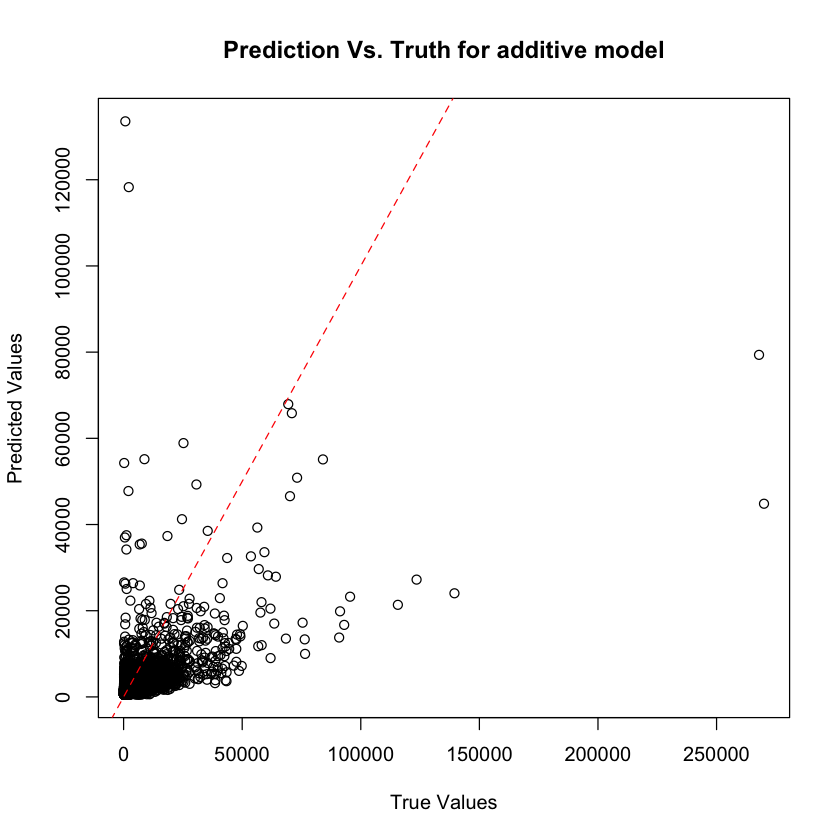

In [80]:
full_preds <- predict(model_add, newdata = git_te, type = "response")
plot(git_te$Stars, full_preds, main = "Prediction Vs. Truth for additive model", 
    xlab = "True Values", ylab = "Predicted Values")
abline(a = 0, b = 1, col = "red",lty = 2)

The additive model using number of issues, forks, size of the repository, and discussion setting is performs very similarly to the full model with the same $R^2$ score and slightly worse root mean sqeuared error (RMSE) on the testing set. Also, the $p$-value for the estimated coeffecient of size is higher than $5\%$ indicating not-significance for the size variable in our model. Since the new additive model is less complex than the full model and perfoms as good as the full model, the new additive model is prefered over the full model. The truth versus predictions plot is similar to the one of the additive model and shows the same trend.

In [39]:
inter_model <- lm(Stars ~ Issues * Has.Discussions * Forks, data = git_tr)
inter_model_summary <- summary(inter_model)
inter_model_summary %>% tidy() %>% mutate_if(is.numeric, round, 2)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),456.43,8.62,52.96,0
Issues,4.67,0.06,76.32,0
Has.DiscussionsTrue,468.07,25.35,18.46,0
Forks,1.72,0.01,238.31,0
Issues:Has.DiscussionsTrue,-2.42,0.11,-21.52,0
Issues:Forks,0.00,0.00,-102.58,0
Has.DiscussionsTrue:Forks,1.26,0.02,68.83,0
Issues:Has.DiscussionsTrue:Forks,0.00,0.00,12.37,0


In [40]:
results <- evaluate_model("interaction model", inter_model, results)
results

Model,data,r_sqr,rmse,adj_r_sqr
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean model,train,0.00,4134.00,0.00
mean model,test,0.00,3533.14,0.00
full model,train,0.36,3312.00,0.36
full model,test,0.37,2796.82,0.37
additive model,train,0.36,3318.00,0.36
additive model,test,0.37,2803.20,0.37
interaction model,train,0.43,3125.00,0.43
interaction model,test,0.42,2700.39,0.42


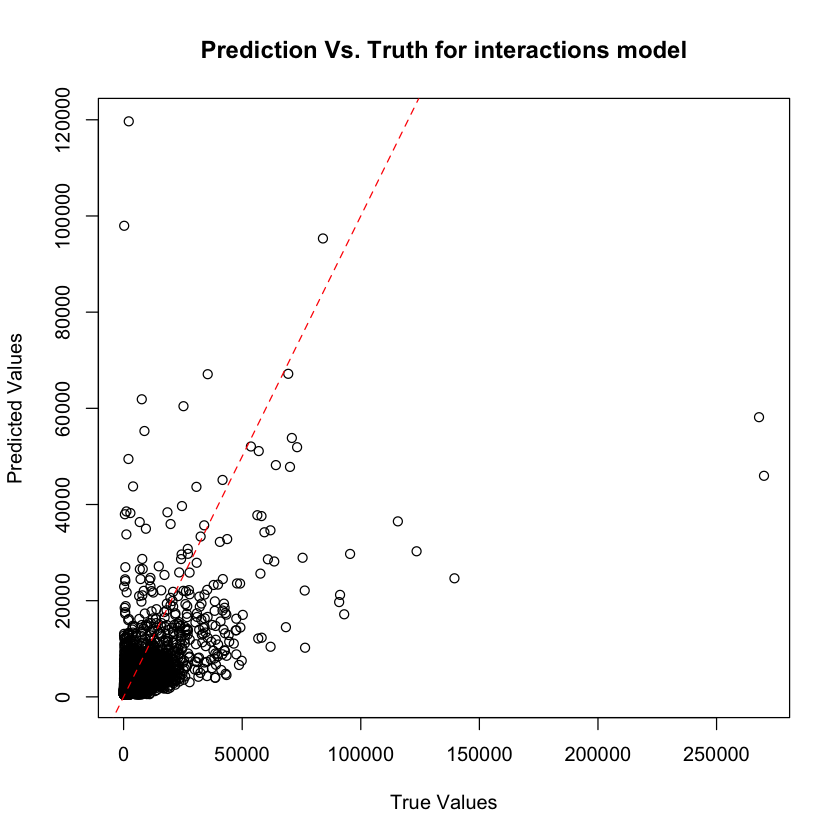

In [81]:
full_preds <- predict(inter_model, newdata = git_te, type = "response")
plot(git_te$Stars, full_preds, main = "Prediction Vs. Truth for interactions model", 
    xlab = "True Values", ylab = "Predicted Values")
abline(a = 0, b = 1, col = "red",lty = 2)

The interaction model shows some improvements to the $R^2$ and root mean squared error (RMSE) for both training and testing data. However, that comes at the expense of interpretability. Moreover, the model shows the same trend in the truth versus predictions plot with slight improvements that are observed in haveing more points closer to the line.

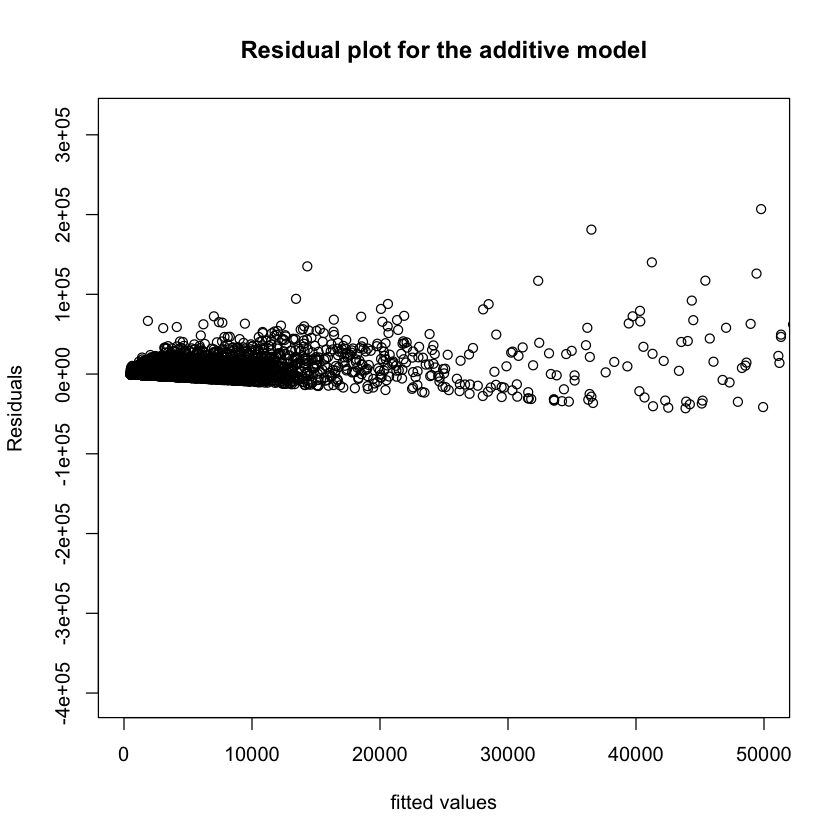

In [70]:
plot(model_add$fitted.values, model_add$residuals, xlim=c(0, 50000), 
    main = "Residual plot for the additive model", 
    xlab = "fitted values", ylab = "Residuals")

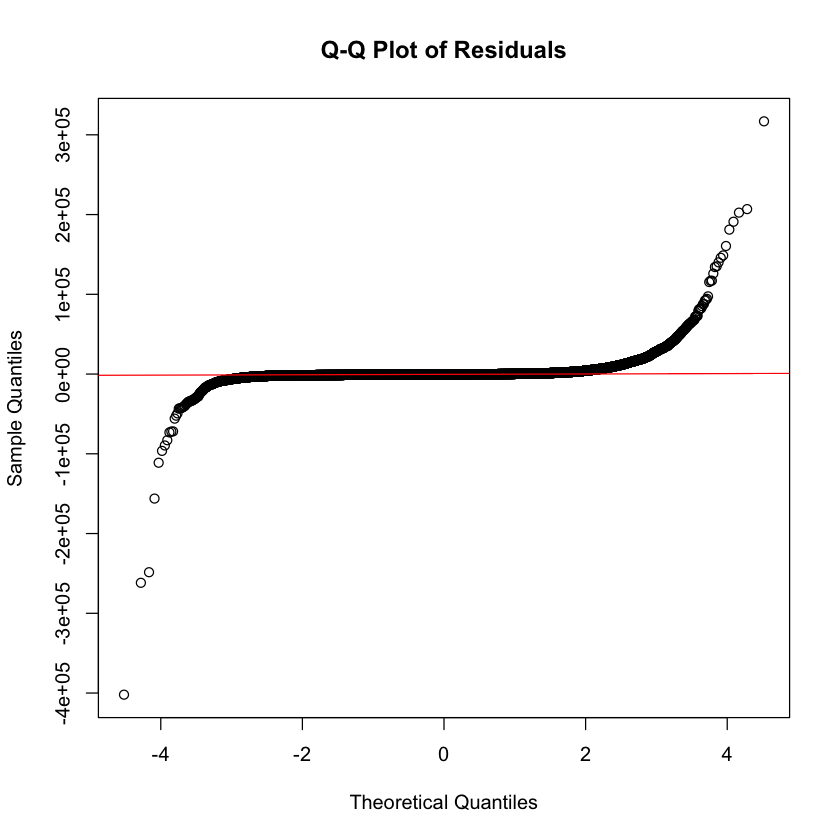

In [60]:
qqnorm(model_add$residuals, main = "Q-Q Plot of Residuals")
qqline(model_add$residuals, col = "red")

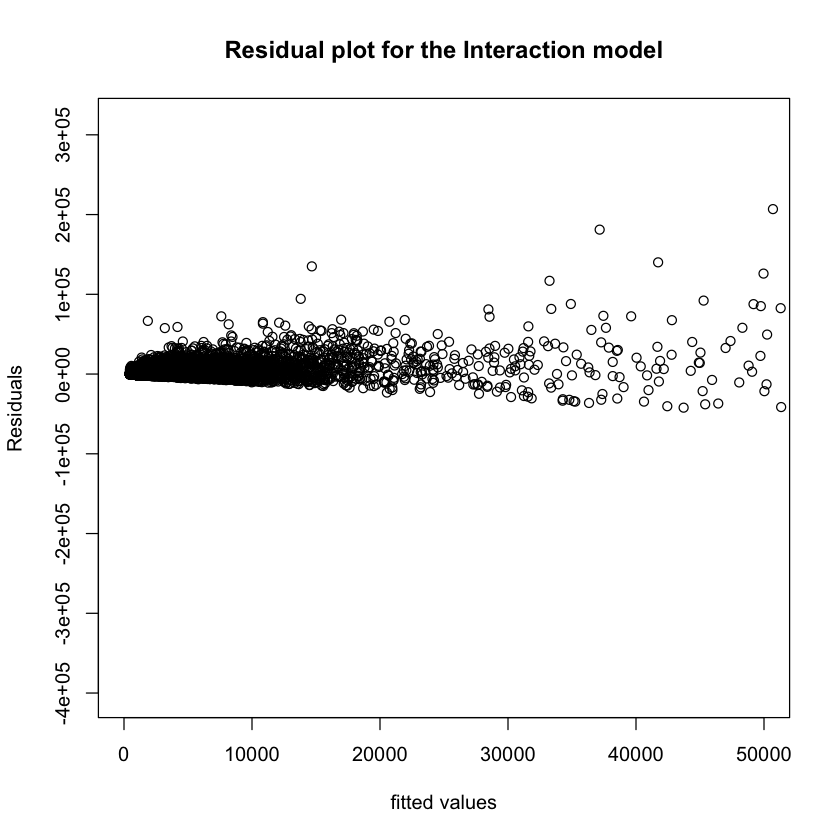

In [71]:
plot(inter_model$fitted.values, model_add$residuals, xlim=c(0, 50000), 
    main = "Residual plot for the Interaction model", 
    xlab = "fitted values", ylab = "Residuals")

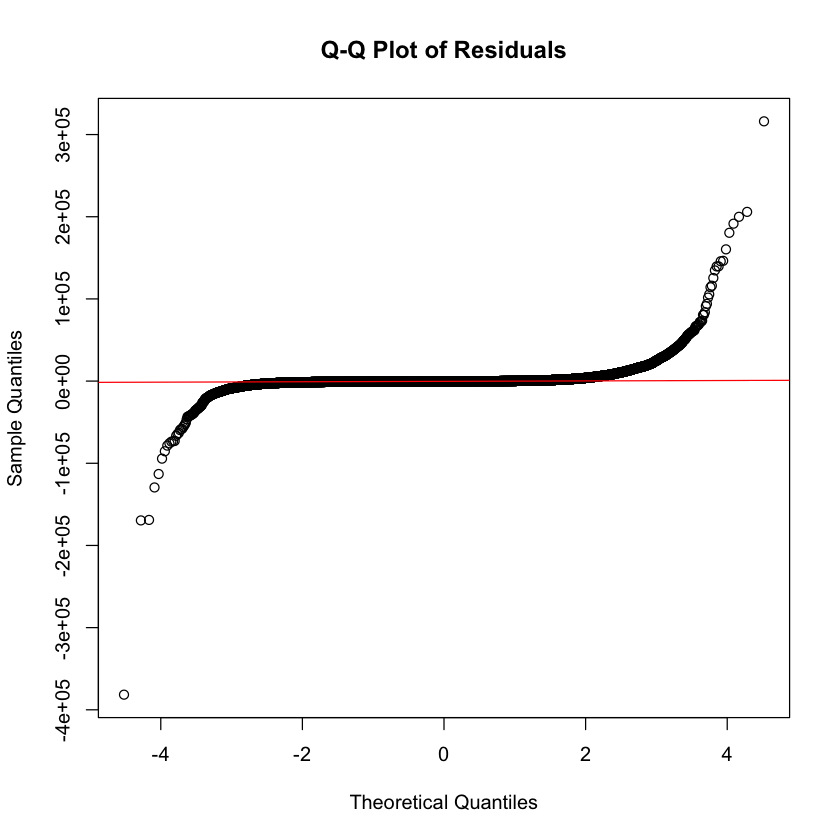

In [72]:
qqnorm(inter_model$residuals, main = "Q-Q Plot of Residuals")
qqline(inter_model$residuals, col = "red")

The residuals plots for the interaction model and the additive model are very similar and show a funnel shape, indicating that the errors violate the assumption of equal variance. Moreover, the Q-Q plot shows violation of the assumption of normality of the error terms. Although the model with interactions performed slightly better than the additive model, the additive model is more interpretable and easier to understand. Thus, the additive model is our choice for this project. 